In [1]:
import pandas as pd
import logging
import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval
from sksfa import SFA
from seisLM.model import supervised_models

# from seisLM.utils.project_path import gitdir
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from seisLM.utils import project_path
from seisLM.model import pretrained_models

from torchinfo import summary
from seisLM.data_pipeline import dataloaders

In [2]:
model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-10-22h-22m-38s/checkpoints/epoch=1-step=279530.ckpt'
# model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/ethz_seisLM/42__2024-06-07-10h-43m-45s/checkpoints/epoch=28-step=5104.ckpt'

pretrained_model = pretrained_models.LitMultiDimWav2Vec2.load_from_checkpoint(
    model_name_or_path
)
# make sure that the gata generator contains labeled data
pretrained_model.get_train_augmentations = supervised_models.PhaseNetLit().get_augmentations
pretrained_model.get_val_augmentations = supervised_models.PhaseNetLit().get_augmentations

pretrained_model.eval();

summary(pretrained_model.model, input_size=(1, 3, 3001) )


2024-06-12 01:14:01,040 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-06-12 01:14:01,564 | seisbench | WARNING | Skipping preload, as cache is disabled.
2024-06-12 01:14:01,565 | seisbench | WARNING | Skipping preload, as cache is disabled.


Layer (type:depth-idx)                                            Output Shape              Param #
MultiDimWav2Vec2ForPreTraining                                    --                        --
├─MultiDimWav2Vec2Model: 1-1                                      [1, 2999, 256]            240
│    └─Wav2Vec2FeatureEncoder: 2-1                                [1, 256, 2999]            --
│    │    └─ModuleList: 3-1                                       --                        3,072
│    └─Wav2Vec2FeatureProjection: 2-2                             [1, 2999, 240]            --
│    │    └─LayerNorm: 3-2                                        [1, 2999, 256]            512
│    │    └─Linear: 3-3                                           [1, 2999, 240]            61,680
│    │    └─Dropout: 3-4                                          [1, 2999, 240]            --
│    └─Wav2Vec2EncoderStableLayerNorm: 2-3                        [1, 2999, 240]            --
│    │    └─Wav2Vec2PositionalConvEm

Seed set to 1
2024-06-12 01:28:12,394 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-06-12 01:28:12,865 | seisbench | WARNING | Skipping preload, as cache is disabled.
2024-06-12 01:28:12,867 | seisbench | WARNING | Skipping preload, as cache is disabled.


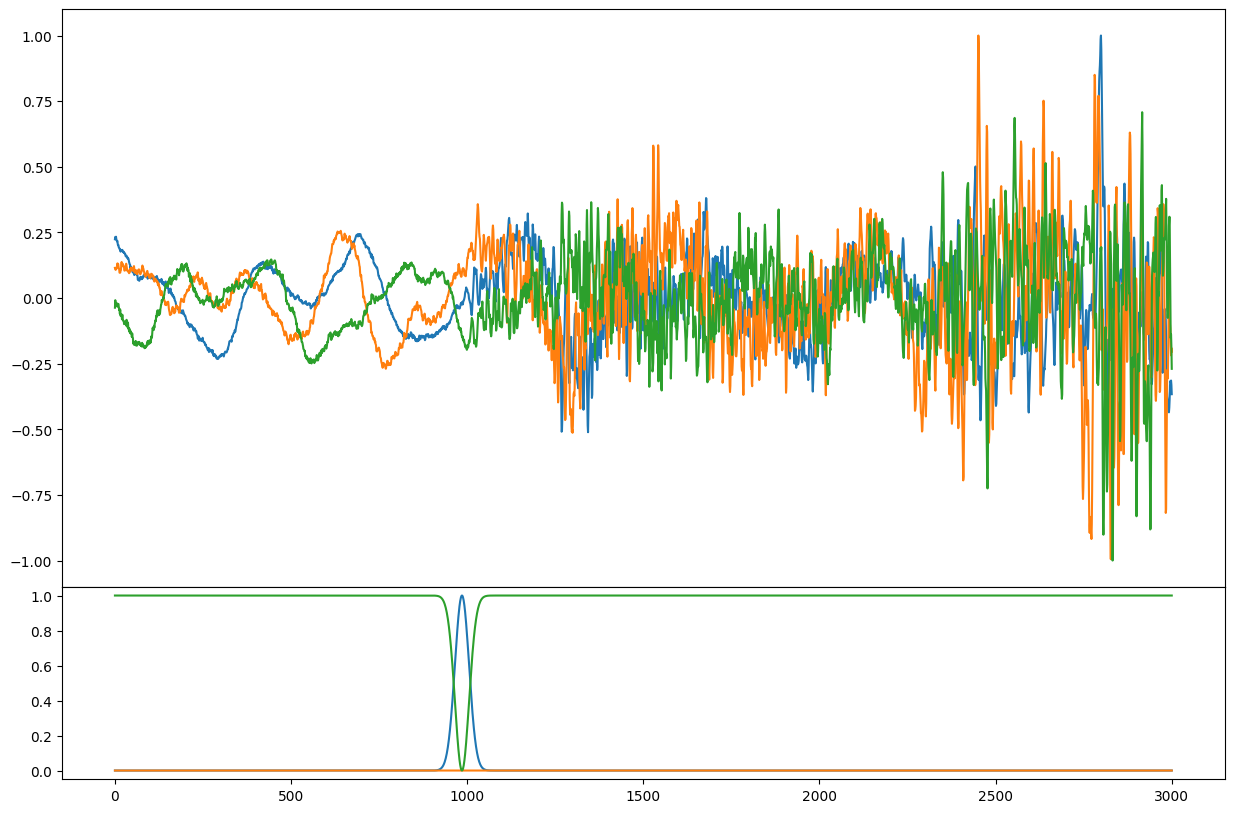

In [25]:
from lightning.pytorch import seed_everything

seed_everything(1)
train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
    model=pretrained_model,
    data_names='ETHZ',
    batch_size=1,
    num_workers=2,
)

batch = next(iter(train_loader))

sample_x = batch['X'][0]
sample_y = batch['y'][0]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample_x.T)
axs[1].plot(sample_y.T)


In [26]:
with torch.no_grad():
  out = pretrained_model.model(batch['X'].cuda())
  features = out['projected_states']
  
single_sample_feature = features.detach().cpu().numpy()[0]
  


In [27]:
sfa = SFA(n_components=1)
# print(sample_x.T.shape)
slow_contextualized_features = sfa.fit_transform(
  single_sample_feature
)
slow_input_features  = sfa.fit_transform(
  sample_x.T
)

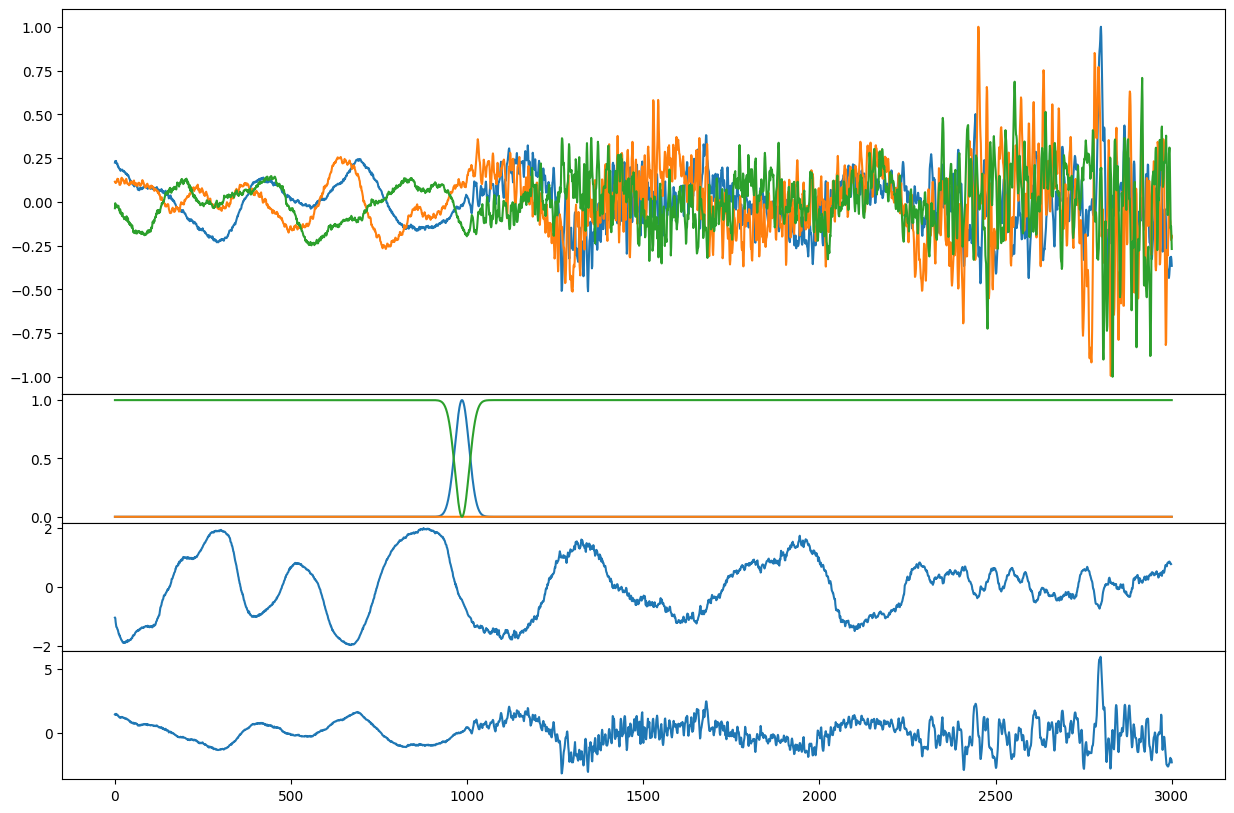

In [28]:

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1, 1]})
axs[0].plot(sample_x.T)
axs[1].plot(sample_y.T)
axs[2].plot(slow_contextualized_features)
axs[3].plot(slow_input_features)

